#  Predicting the success of a bank deposit marketing campaign

The dataset we will use in this project is available for public and related with direct marketing campaigns of a Portuguese banking institution (check for the details here: [Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.)

The goal of this project is to predict if the client will subscribe to a term deposit (variable y).

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Set seaborn 
sns.set_style("whitegrid")
sns.set(font_scale=1.2)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Let's loaf the data set and inspect its content.

In [2]:
#Load data
bank=pd.read_csv('bank_part.csv')

In [3]:
# Look at the data
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,29,admin.,single,secondary,no,428,yes,yes,cellular,7,may,54,1,345,2,failure,no
1,30,admin.,single,secondary,no,818,yes,yes,cellular,16,apr,66,1,346,1,failure,no
2,36,self-employed,single,tertiary,no,353,no,no,cellular,11,aug,361,2,181,2,success,yes
3,35,services,divorced,secondary,no,440,yes,no,cellular,5,feb,103,1,248,1,failure,no
4,60,technician,married,secondary,no,1139,no,no,cellular,6,feb,67,2,207,2,failure,no


### Checking for missing variables

In [4]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4264 non-null   int64 
 1   job        4264 non-null   object
 2   marital    4264 non-null   object
 3   education  4264 non-null   object
 4   default    4264 non-null   object
 5   balance    4264 non-null   int64 
 6   housing    4264 non-null   object
 7   loan       4264 non-null   object
 8   contact    4264 non-null   object
 9   day        4264 non-null   int64 
 10  month      4264 non-null   object
 11  duration   4264 non-null   int64 
 12  campaign   4264 non-null   int64 
 13  pdays      4264 non-null   int64 
 14  previous   4264 non-null   int64 
 15  poutcome   4264 non-null   object
 16  y          4264 non-null   object
dtypes: int64(7), object(10)
memory usage: 566.4+ KB


The data contains 17 columns with 4264 variables in each column. As we can see, none of the columns contain null values.

The columns of the data frame contain the following variables:
* age(numeric)
* job: type of job (categorical: "admin.","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services") 
* arital: marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
* education (categorical: "secondary","primary","tertiary")
* default: has credit in default? (binary: "yes","no")
* balance: average yearly balance, in euros (numeric) 
* housing: has housing loan? (binary: "yes","no")
* loan: has personal loan? (binary: "yes","no")
    
* contact: contact communication type (categorical:"telephone","cellular") 
* day: last contact day of the month (numeric)
* month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
* duration: last contact duration, in seconds (numeric)

    
* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
* previous: number of contacts performed before this campaign and for this client (numeric)
* poutcome: outcome of the previous marketing campaign (categorical: "failure","success")

* y: has the client subscribed a term deposit? (binary: "yes","no") 


Let's rename the target column (column 'y') so the column name is more informative.

In [5]:
# Rename the target column
bank.rename(columns={'y':'subscription'},inplace=True)

## Exploratory Data Analysis

Let's start with some exploratory data analysis. We will look at every variable and see how different variables were related to
the outcome of the deposit marketing campaign.


### How many bank clients subscribed to the deposit?

In [6]:
bank['subscription'].value_counts()

no     3227
yes    1037
Name: subscription, dtype: int64

In [7]:
bank['subscription'].value_counts(normalize=True)

no     0.756801
yes    0.243199
Name: subscription, dtype: float64

We can se that approximately 24.3% of bank clients who were contacted during the campaign subscribed to the deposit and around 75.7% did not sunbscribe.

Since the data is only mildly imbalanced, we will try to train our models without applying any techniques to address it.

### Is customer's age related to the marketing campaign outcome?

In [8]:
#Function to plot feature distribution

def distribution_plot(df,colname,title,hist=True,bins=30):
    
    f, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title,fontsize=18)
    sns.distplot(df[colname],bins=bins,ax=ax)
    plt.show()

In [9]:
# Function to plot subscription density by feature

def subsription_dist_by_feature(df,colname,title):
    
    f, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title,fontsize=18)
    
    sns.kdeplot(data=df,x=colname,hue='subscription',shade=True,ax=ax).set_xlabel(colname)
    plt.show()

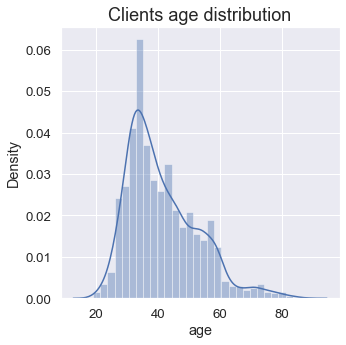

In [10]:
distribution_plot(bank,'age','Clients age distribution')

We can see that the distribution of customers' ages is right-skewed: the most represented age group is 28-34 years old,
and for customers older than 34 the representation of the age groups overall decreases for higher ages.

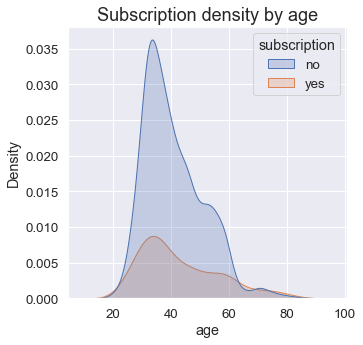

In [11]:
subsription_dist_by_feature(bank,'age','Subscription density by age')

As shown by the plot, customer's age affected campaign outcome. We can see, that for the lowest customer's age group (under 23),
the percentage of subscribed customers was even higher than that of non-subscribers, for customers over 23 the percentage of 
non-subscribers was significantly higher than that of subscribed clients and this difference increased as clients age invreased 
till 34. For clients over 34 years old, the difference between the persentages of non-subscribers and subscribers overally 
decreased. For clients over 65, the number of subscribers and non-subscribers was roughly the same (for some ages, the percentage 
                                                            of clients who subscribed was even higher than the percentage of non-subscribers)

### Is customer's job type related to the marketing campaign outcome?

In [12]:
# Plot to compare categories' infuelnce on subscription outcome

def countplot_compare(df,colname1,colname2,title,fsize):
    
    f, ax = plt.subplots(figsize=fsize)
    ax.set_title(title,fontsize=18)
    
    sns.countplot(x=colname1,hue=colname2, data=df,ax=ax)
    plt.show()   

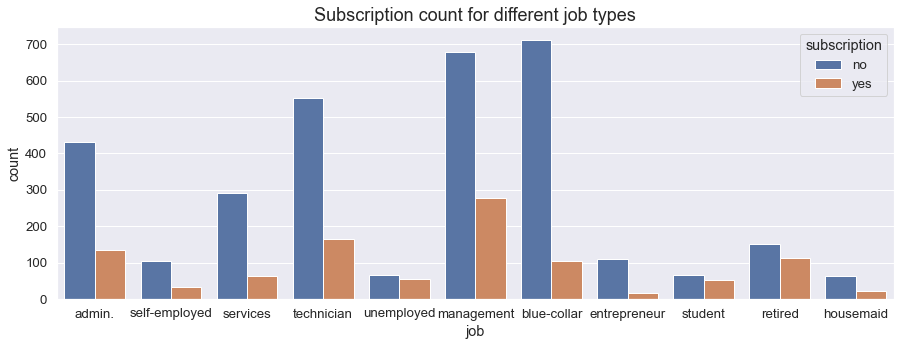

In [13]:
countplot_compare(bank,'job','subscription','Subscription count for different job types',(15,5))

We can see that among the contacted clients, the most represented job types were 'blue-collar','management job','technician'
and 'administrative'.

In [14]:
# Function to compare percentages of subscribers and non-subscribers among categorical variables
def plot_cat_perc(df,colname1,colname2,title,height,aspect):
    
    df1 = df.groupby(colname1)[colname2].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()
    
    g = sns.catplot(x=colname1,y='percent',hue=colname2,data=df1,kind='bar',height=height, aspect=aspect)
    
    g.ax.set_ylim(0,100)
    g.ax.set_title(title,fontsize=18)

    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt,fontsize=16)
      
    plt.show()

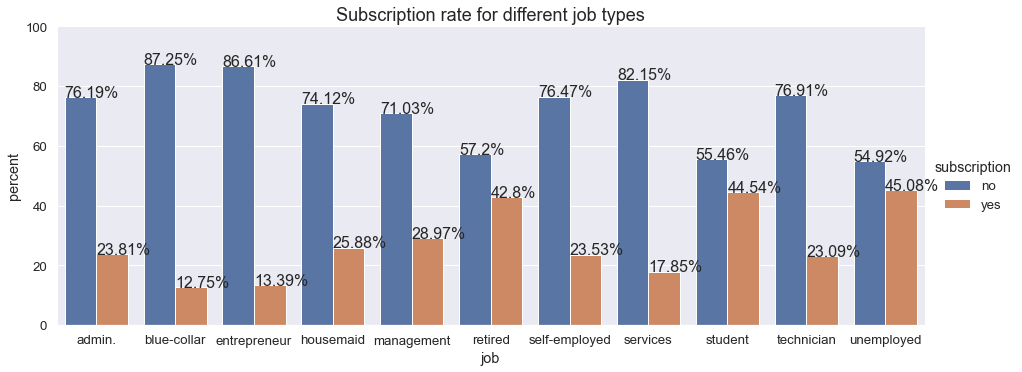

In [15]:
plot_cat_perc(bank,'job','subscription','Subscription rate for different job types',5,13/5)

Overall, the client's job type affected the outcome of the campaign. 

As it is easy to see, the highest percentage of deposit subscription was for unemployed and retired customers as well as for
students, although these categories were not the most represented ones in this campaign.

The lowest percentage of clients who subscribed to deposit was for customers who had 'blue-collar' and 'entrepreneur' job types.

### Does costomer's marital stus affect the marketing campaign outcome?

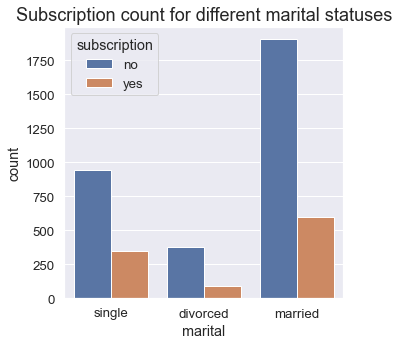

In [16]:
countplot_compare(bank,'marital','subscription','Subscription count for different marital statuses',(5,5))

Evidently, the majority of the contacted clients were married, and the group of clients who were divorced was the least represented
in this campaign.

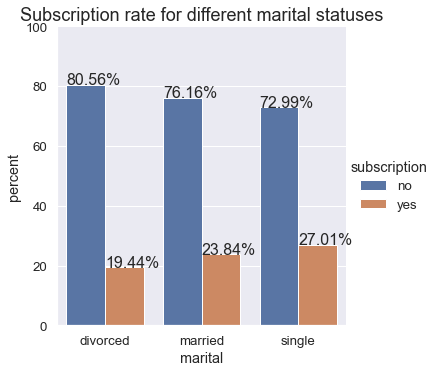

In [17]:
plot_cat_perc(bank,'marital','subscription','Subscription rate for different marital statuses',5,5/5)

As can be seen,clients marital status affected the outcome of the camaign.
The highest subscription percentage was observed for single clients, whereas the lowest subscribtion percentage
was among divorced clients.

### Does education level affect the marketing campaign?

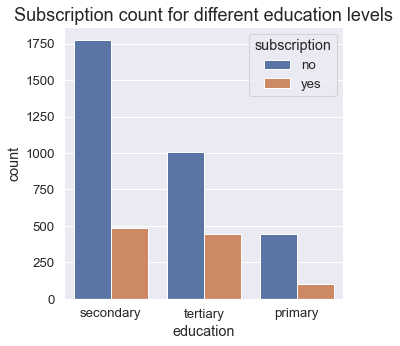

In [18]:
countplot_compare(bank,'education','subscription','Subscription count for different education levels',(5,5))

We can see that the majority of the contacted bank clients had the secondary education.

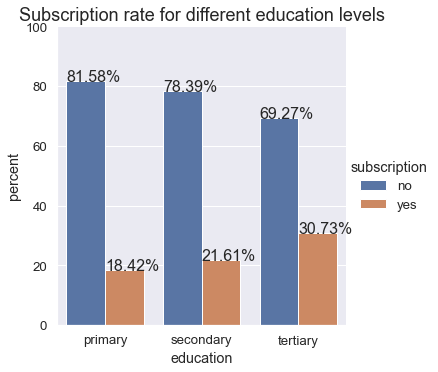

In [19]:
plot_cat_perc(bank,'education','subscription','Subscription rate for different education levels',5,5/5)

Overall, the education level had some effect on the outcome of the campaign. The highest percentage of subscribers was observed
for customers with tertiary education, and the lowest percentage of subscribers was among customers with primary education.

### Does default stus affect the marketing camapign outcome?

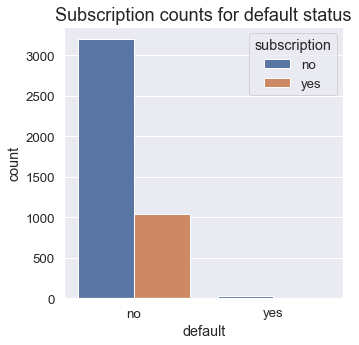

In [20]:
countplot_compare(bank,'default','subscription','Subscription counts for default status',(5,5))

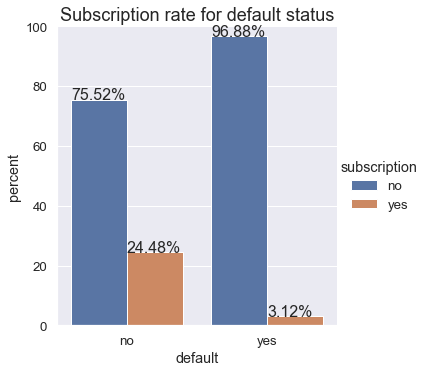

In [21]:
plot_cat_perc(bank,'default','subscription','Subscription rate for default status',5,5/5)

We can see that default status significantly affects clients subscription (the subscription rate is significantly higher for 
clients without default), however the percentage of defaults among all contacted customers is very low so default status
generally did not affect the camapign.

A general recommendation for the future campaigns would be to avoid contacting customers with positive default status.

### Does clients' yearly balance affect the marketing campaign outcome?

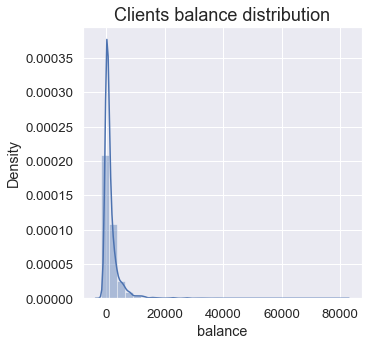

In [22]:
distribution_plot(bank,'balance','Clients balance distribution')

In [23]:
bank['balance'].describe()

count     4264.000000
mean      1615.070356
std       3149.297499
min      -1884.000000
25%        182.000000
50%        625.000000
75%       1840.750000
max      81204.000000
Name: balance, dtype: float64

We can see that the clients' yearly balance distribution is right-skewed with the mean yearly balance of 1615 euros and
with the maximum value of 81204 euros and the minimum of -1884 euros (note that the balance can be negative).

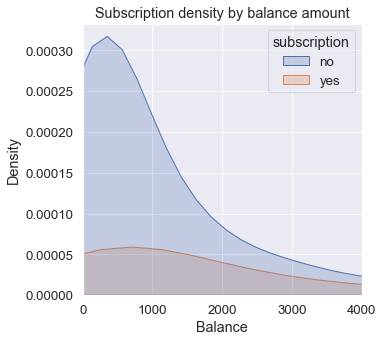

In [24]:
f, ax = plt.subplots(figsize=(5,5))
ax.set_title('Subscription density by balance amount')
ax.set_xlim(0,4000)
    
sns.kdeplot(data=bank,x='balance',hue='subscription',shade=True,ax=ax).set_xlabel('Balance')
plt.show()

It is evident that the probability of subscription to deposit is higher for customers with higher yearly balances (the ratio of 
subscribers over non-subscribers increases with the amount of the balance) which is what is expected as customers with higher
balance have extra money they do not actively use which can be placed into a deposit.

### How the fact of having a housing loan affects the marketing campaign outcome?

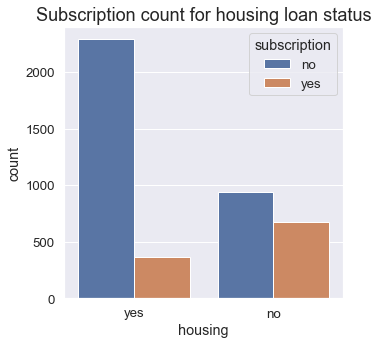

In [25]:
countplot_compare(bank,'housing','subscription','Subscription count for housing loan status',(5,5))

As it can be seen, the majority of contacted clients had a housing loan.

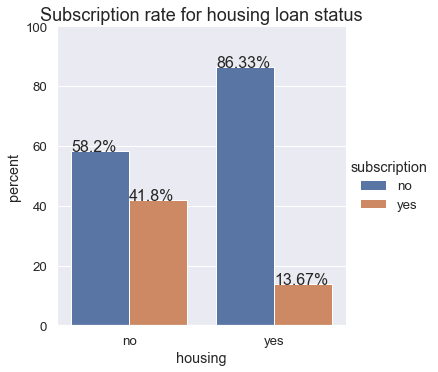

In [26]:
plot_cat_perc(bank,'housing','subscription','Subscription rate for housing loan status',5,5/5)

It is evident that the subscription probability for clients who did not have a housing loan was significantly higher than 
the subscription probability among clients with such loan. This makes a lot of sence sicnce people with a housing loan 
are more likely to have no extra money for a deposit as they need to repay their loan.

### How the fact of having a personal loan affects the marketing campaign outcome?

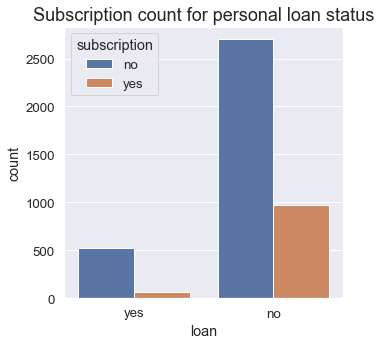

In [27]:
countplot_compare(bank,'loan','subscription','Subscription count for personal loan status',(5,5))

Interestingly, among the clients contacted during the campaign the number of people who did not have any personal loan was
higher than the number of clients with such a loan (quite the opposite was observed for housing loans).

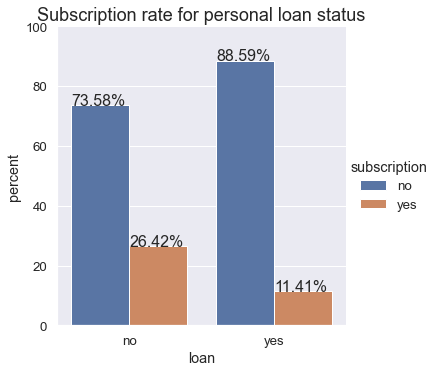

In [28]:
plot_cat_perc(bank,'loan','subscription','Subscription rate for personal loan status',5,5/5)

Again, as in the case of the housing loan, the probability of subscription to a deposit is higher for customers without any
personal loans.

### How the marketing campaign outcome was affected by the means costumers were contacted?

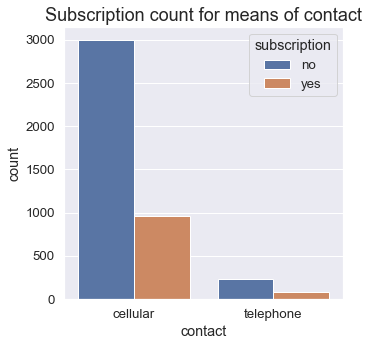

In [29]:
countplot_compare(bank,'contact','subscription','Subscription count for means of contact',(5,5))

We can see that the majority of the customers were contacted via cellular phone and only a small amount of people were contacted
by telephone.

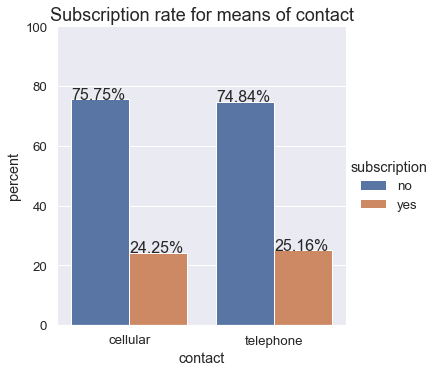

In [30]:
plot_cat_perc(bank,'contact','subscription','Subscription rate for means of contact',5,5/5)

We can see that the probability of subscription was roughly the same when people were contacted by either cellular phone or telephone.
Thus, this variable did not affect the outcome of the campaign that much. 

### Does the day of the month matter for the outcome of the marketing campaign?

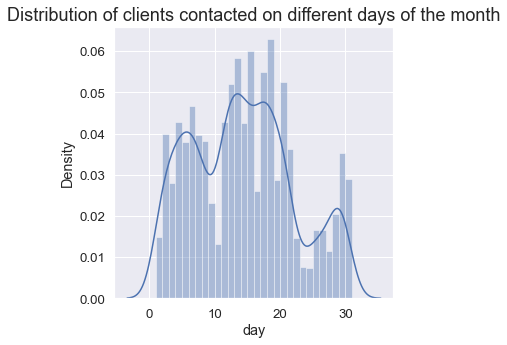

In [31]:
distribution_plot(bank,'day','Distribution of clients contacted on different days of the month')

Interestingly, on some days the amount of contated customers was unusually low. This is the case of days 11, 23, 24 and 28,
however we will not hypothesize about the reasons of this phenomenon as it is out of scope of this project.

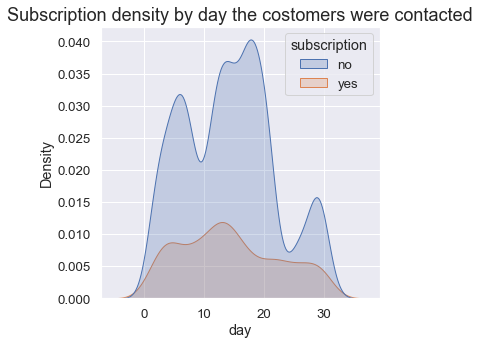

In [32]:
subsription_dist_by_feature(bank,'day','Subscription density by day the costomers were contacted')

We can see that the difference between the percentages of non-subscribers and subscribers 
(and thus the probability of subscription) changes over different days of the month. 

Interestingly, on the days with the lowest
number of contacted clients (days 23 and 24) the probability of subscription was very high (the difference beetween
                                                                                            the percentages of non-subscribers
                                                                                                    and subscribers was very low).
We can speculate that this high subscription probability is due to the fact that the days 23-24 of the month usually correspond to
the pay day, which can affect a client's willingness to subscribe to a deposit.


### Does it matter during which month we will carry out the campaign?

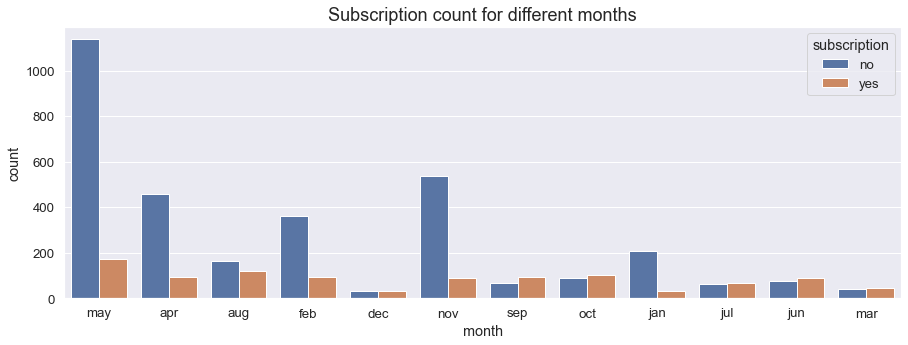

In [33]:
countplot_compare(bank,'month','subscription','Subscription count for different months',(15,5))

As it can be seen, the majority of the clients in the campaign were contacted in May and the smallest amount of customers was contacted in March.

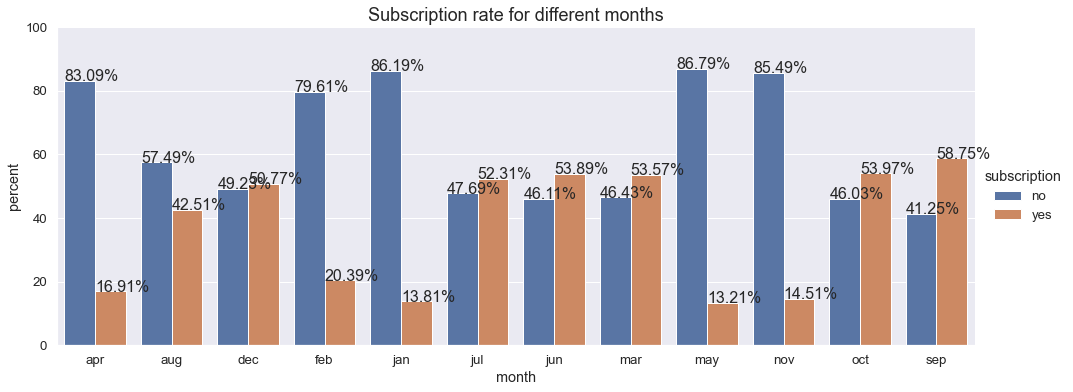

In [34]:
plot_cat_perc(bank,'month','subscription','Subscription rate for different months',5.27,13.7/5.27)

It is easy to see that the month of the year when customers were contacted had significant effect on the outcome of the campaign.

Strikingly, the probability of subscribtion was higher than 50% for the clients contacted in September, October, March, June, July and December,
whereas for customers conacted in May, November, January and April the probability of subscription was lower than 20%.

### Does the marketing campaign outcome is related to the last contact duration?

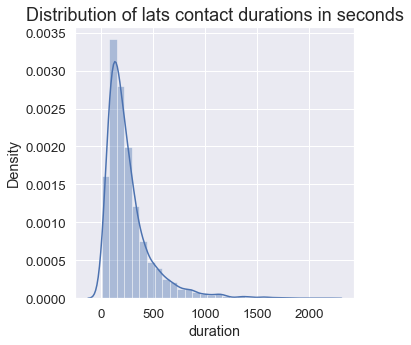

In [35]:
distribution_plot(bank,'duration','Distribution of lats contact durations in seconds')

We can see that most of the last clients' contacts lasted between 70 and 220 seconds, and some contacts lasted up to 2000 seconds.

Let's analyze how the contact durations were related to the subscription probability.

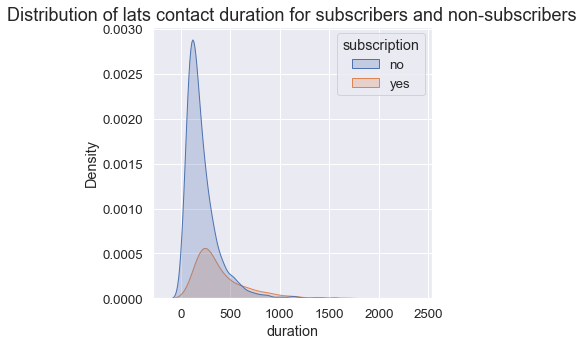

In [36]:
subsription_dist_by_feature(bank,'duration','Distribution of lats contact duration for subscribers and non-subscribers')

We can clearly see that for longer call durations the subscription probability was higher. Also, for the contacts that
lasted more than 650 seconds the probability of client's subscription to the deposit was higher than the probability of a subscription
refusal.

### Does number of contacts performed in this campaign matter for the outcome of the campaign?

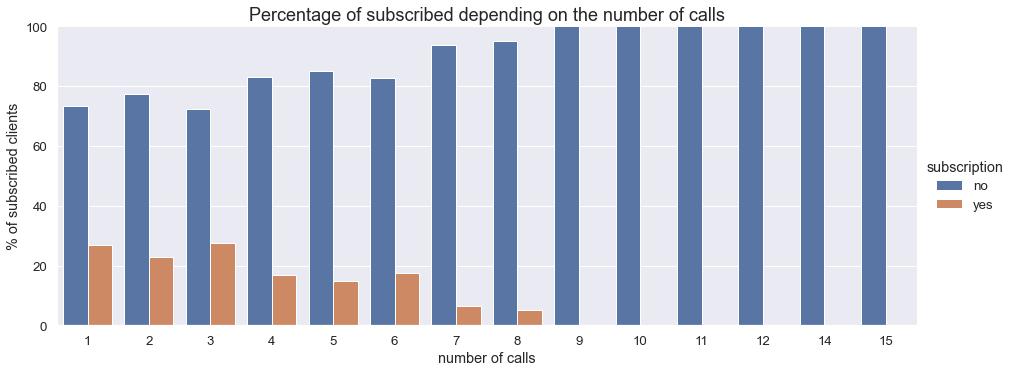

In [37]:
df = bank.groupby('campaign')['subscription'].value_counts(normalize=True)
df = df.mul(100)
df = df.rename('percent').reset_index()
    
g = sns.catplot(x='campaign',y='percent',hue='subscription',data=df,kind='bar',height=5, aspect=13/5)
    
g.ax.set_ylim(0,100)
g.ax.set_title('Percentage of subscribed depending on the number of calls',fontsize=18)
g.ax.set_xlabel('number of calls')
g.ax.set_ylabel('% of subscribed clients')

plt.show()

We can see that,as an overall trend, the number of contacts performed in the campaign matters for the campaign's outcome. 

Although, the percentage of subscribers was really similar for the clients who were contacted from one to three
times in this campaign. Interestingly, for the group of clients who were contacted trice in this campaign
the percentage of subscribers was the highest.

When the number of contacts exceeded three, the percentage of subscribers generally decreased with the number of calls 
performed during the current campaign.

### Does the number of days that passed by after the client was last contacted from a previous campaign matter?

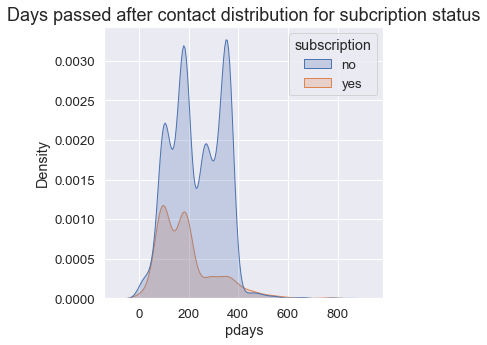

In [38]:
subsription_dist_by_feature(bank,'pdays','Days passed after contact distribution for subcription status')

We can see that the number of days that passed by after the client was last contacted from a previous campaign really
mattered for the current campaign's outcome.

The probability of subscription dropped drastically for the group of clients who were contacted more than 230 days before  
from a previous campaign.

However, for the clients who were contacted more than 410 days before from a previos campaign,
the subscription probability was even higher than 50%, although we can see from the plot that the total amount of these customers was very low and
they generally did not matter for the campaign's outcome.

### Does number of contacts performed before this campaign matters for the campaign outcome?

Now, we will analyze how the number of contacts for the same client performed before this campaign affected
the results of the current campaign.

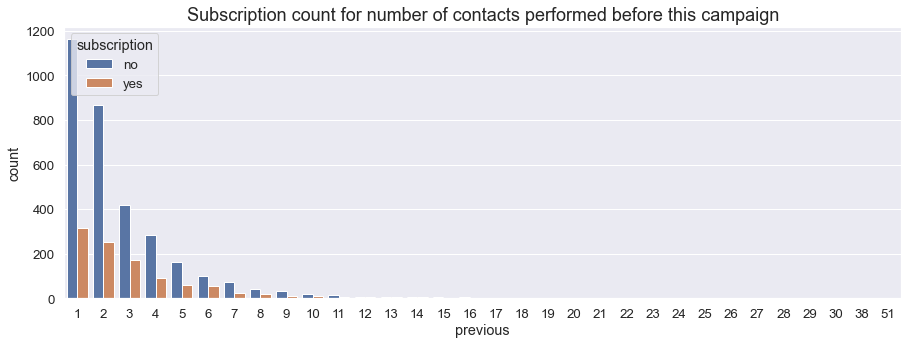

In [39]:
countplot_compare(bank,'previous','subscription','Subscription count for number of contacts performed before this campaign',(15,5))

We can see that most of the clients were contacted only once before the campaign. Also, a significant amout of customers
were contacted two, three or four times before the current campaign.

Very few customers were contacted more than 11 times, so we will further analyze the subscription probability for the
clients who were contacted less than 12 times before the current campaign.

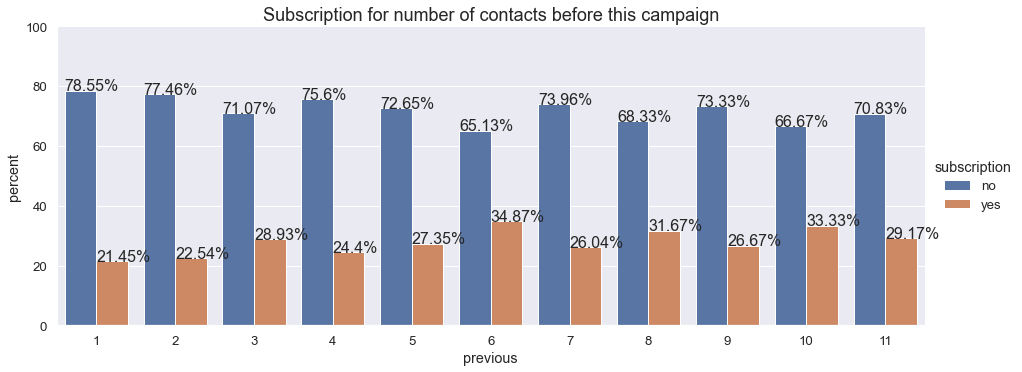

In [40]:
plot_cat_perc(bank[bank.previous<12],'previous','subscription','Subscription for number of contacts before this campaign',5,13/5)

We can see that overall the number of previous contacts affected clients' desicions on whether subscribe or not to deposit.

For clients who were contacted only once or twice before this campaign, the subscription probability was the lowest: 21.45% and 22.54%
respectively. 

Interestingly, for the customers who were contacted six, eight or ten times, the subscription probability was the highest:
        34.87%,31.67% and 33.33% correspondingly.
        
However, overall there is no clear relation between the number of contacts performed before and the outcome of the current campaign.

### Did outcome of the previous marketing campaign affect subscription?

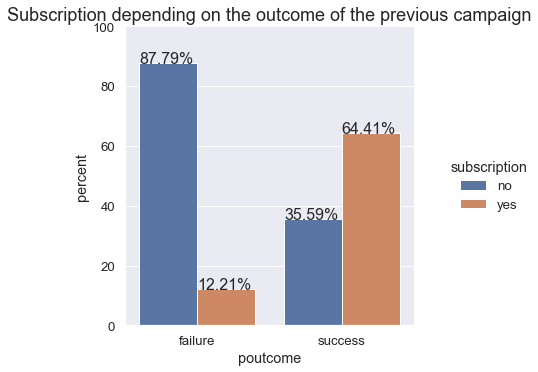

In [41]:
plot_cat_perc(bank,'poutcome','subscription','Subscription depending on the outcome of the previous campaign',5,5/5)

We can see that the outcome of the previous campaign definetely affected the current campaign: the subscription probability
among the clients who subscribed during the previous campaign was around 64.4%, whereas among the clients who did not subscibe
the previous time, only around 12.2% subscribed during the current campaign. 

## Feature Engineering

In [42]:
bank.isnull().sum()

age             0
job             0
marital         0
education       0
default         0
balance         0
housing         0
loan            0
contact         0
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome        0
subscription    0
dtype: int64

### Pay day feature

In [43]:
bank.loc[(bank['day']==23)|(bank['day']==24)|(bank['day']==22), 'pay_day'] = 1
bank.loc[(bank['day']!=23)&(bank['day']!=24)&(bank['day']!=22), 'pay_day'] = 0
bank['pay_day'].value_counts()                           

0.0    4139
1.0     125
Name: pay_day, dtype: int64

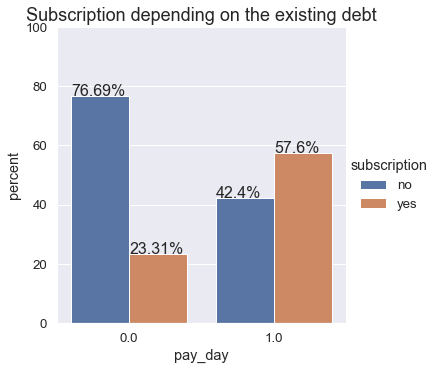

In [44]:
plot_cat_perc(bank,'pay_day','subscription','Subscription depending on the existing debt',5,5/5)

The subscription rate is higher if the customer is contacted on a pay date.

### Negative balance feature

In [45]:
bank.loc[bank['balance'] < 0, 'negative_balance'] = 1
bank.loc[bank['balance'] >= 0, 'negative_balance'] = 0
bank['negative_balance'].value_counts()

0.0    4023
1.0     241
Name: negative_balance, dtype: int64

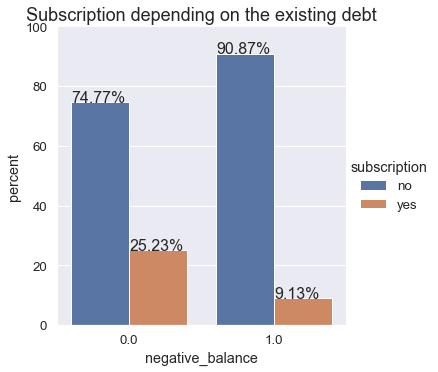

In [46]:
plot_cat_perc(bank,'negative_balance','subscription','Subscription depending on the existing debt',5,5/5)

### Group previous contacts

In [47]:
bank.loc[bank['previous'] > 10, 'previous'] = 11

### Group days passed after last contact: pdays

In [48]:
bank.loc[bank['pdays'] < 230, 'pdays_group'] = 'B'
bank.loc[(bank['pdays'] >= 230)&(bank['pdays'] <= 410), 'pdays_group'] = 'C'
bank.loc[bank['pdays'] > 410, 'pdays_group'] = 'A'

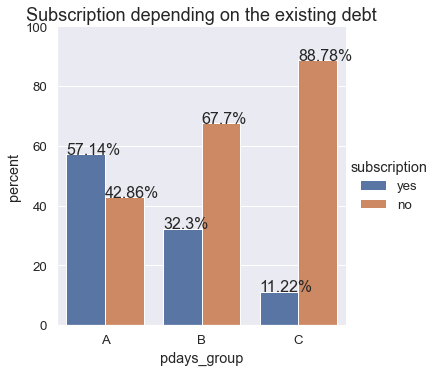

In [49]:
plot_cat_perc(bank,'pdays_group','subscription','Subscription depending on the existing debt',5,5/5)

### Group age

In [50]:
bank.loc[bank['age'] < 21, 'age_group'] = 'D'
bank.loc[(bank['age'] >= 21)&(bank['age'] <= 40), 'age_group'] = 'C'
bank.loc[(bank['age'] > 40)&(bank['age'] <= 60), 'age_group'] = 'B'
bank.loc[bank['age'] > 60, 'age_group'] = 'A'

### Feature scaling and feature encoding

We will divide the feature variables into three groups: categorical variables, categorical ordinal variables and
numerical variables. Then. we will transform numerical variables with StandardScaler and perform one-hot encoding of
categorical variables and label encoding of ordinal categorical variables.

In [51]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

In [52]:
# Create lists of different types of features
categorical_col=['job','marital','default','housing','loan','contact','month','poutcome','pdays_group']
categorical_ordinal=['education','age_group']
numerical_col=['balance','day','duration','campaign','previous']
#'previous'
#'age',
#'pdays'

In [53]:
# Using StandarScaler to scale the data
scaler=StandardScaler()
scaler.fit(bank[numerical_col])

#Perform scaling
scaled_data = pd.concat([bank[['job','marital','default','housing','loan','contact','month','poutcome',
                            'education','age_group','negative_balance','pay_day','pdays_group']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(bank[numerical_col]), columns=numerical_col)],
                    axis=1)
scaled_data.head()

,job,marital,default,housing,loan,contact,month,poutcome,education,age_group,negative_balance,pay_day,pdays_group,balance,day,duration,campaign,previous
0,admin.,single,no,yes,yes,cellular,may,failure,secondary,C,0.0,0.0,C,-0.376976,-0.926021,-0.889101,-0.666596,-0.353259
1,admin.,single,no,yes,yes,cellular,apr,failure,secondary,C,0.0,0.0,C,-0.253124,0.228264,-0.837886,-0.666596,-0.794600
2,self-employed,single,no,no,no,cellular,aug,success,tertiary,C,0.0,0.0,B,-0.400794,-0.413005,0.421157,0.030575,-0.353259
3,services,divorced,no,yes,no,cellular,feb,failure,secondary,C,0.0,0.0,C,-0.373165,-1.182529,-0.679972,-0.666596,-0.794600
4,technician,married,no,no,no,cellular,feb,failure,secondary,B,0.0,0.0,B,-0.151185,-1.054275,-0.833618,0.030575,-0.353259


In [54]:
#Transforming the data
label_data = scaled_data.copy()
label_encoder = LabelEncoder()

for col in categorical_ordinal:
    label_data[col] = label_encoder.fit_transform(scaled_data[col])
label_data.head()

,job,marital,default,housing,loan,contact,month,poutcome,education,age_group,negative_balance,pay_day,pdays_group,balance,day,duration,campaign,previous
0,admin.,single,no,yes,yes,cellular,may,failure,1,2,0.0,0.0,C,-0.376976,-0.926021,-0.889101,-0.666596,-0.353259
1,admin.,single,no,yes,yes,cellular,apr,failure,1,2,0.0,0.0,C,-0.253124,0.228264,-0.837886,-0.666596,-0.794600
2,self-employed,single,no,no,no,cellular,aug,success,2,2,0.0,0.0,B,-0.400794,-0.413005,0.421157,0.030575,-0.353259
3,services,divorced,no,yes,no,cellular,feb,failure,1,2,0.0,0.0,C,-0.373165,-1.182529,-0.679972,-0.666596,-0.794600
4,technician,married,no,no,no,cellular,feb,failure,1,1,0.0,0.0,B,-0.151185,-1.054275,-0.833618,0.030575,-0.353259


In [55]:
#final_data=label_data.copy()
onehotencoder = OneHotEncoder()
df=label_data.copy()

for col in categorical_col:
    #reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
    X = onehotencoder.fit_transform(label_data[col].values.reshape(-1,1)).toarray()
    
    #To add this back into the original dataframe 
    df_OneHot = pd.DataFrame(X, columns = [col+'_'+str(int(i)) for i in range(X.shape[1])]) 
    
    df = pd.concat([df, df_OneHot], axis=1)
    
    #droping the country column 
    df= df.drop([col], axis=1) 


#printing to verify 
df.head()

,education,age_group,negative_balance,pay_day,balance,day,duration,campaign,previous,job_0,...,month_7,month_8,month_9,month_10,month_11,poutcome_0,poutcome_1,pdays_group_0,pdays_group_1,pdays_group_2
0,1,2,0.0,0.0,-0.376976,-0.926021,-0.889101,-0.666596,-0.353259,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1,2,0.0,0.0,-0.253124,0.228264,-0.837886,-0.666596,-0.794600,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2,2,0.0,0.0,-0.400794,-0.413005,0.421157,0.030575,-0.353259,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1,2,0.0,0.0,-0.373165,-1.182529,-0.679972,-0.666596,-0.794600,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1,1,0.0,0.0,-0.151185,-1.054275,-0.833618,0.030575,-0.353259,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Machine Learning 

Let's now process the data and build machine learning models to predict the outcome of the bank deposit marketing campaign.
As a model performance metric we will use the accuracy and F1 scores, as well as confusion matrix.
We should take into account that it is more important to correctly predict positive outcomes of this campaign so we will
pay special attention to the number of true positive predictions.

### Target column

In [56]:
bank['target']=np.where(bank['subscription']=='yes',1,0)
bank['target'].value_counts(dropna=False)

0    3227
1    1037
Name: target, dtype: int64

There were 1037 positive and 3227 negative outcomes in this campaign.

### Split Data into training and test data

In [57]:
# Split data between train and test data sets
from sklearn.model_selection import train_test_split

X_scaled=df
y=bank['target']

x_train, x_test, y_train,y_test=train_test_split(X_scaled,y,test_size=0.3,random_state=1,stratify=y)

### Logistic Regression

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,precision_score

model_lr=LogisticRegression()
model_lr.fit(x_train,y_train)

LogisticRegression()

In [59]:
pred_test=model_lr.predict(x_test)
pred_train=model_lr.predict(x_train)
print('Model test F1 score: %.5f'% f1_score(y_test,pred_test))
print('Model test accuracy: %.5f'% accuracy_score(y_test,pred_test))
print('Model test precision: %.5f'% precision_score(y_test,pred_test))

Model test F1 score: 0.66316
Model test accuracy: 0.85000
Model test precision: 0.72973


Confusion Matrix


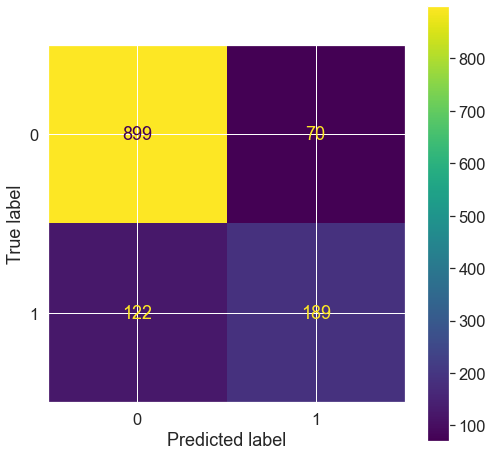

In [60]:
# Plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
sns.set(rc={"figure.figsize":(8, 8)},font_scale=1.5)

print('Confusion Matrix')
plot_confusion_matrix(model_lr, x_test, y_test)

### Tune hyperparameters

In [61]:
C=[0.01,0.1,1,10,100]

for c in C:
    print('C=',c)
    model_lr=LogisticRegression(C=c)

    model_lr.fit(x_train,y_train)

    pred_test=model_lr.predict(x_test)
    pred_train=model_lr.predict(x_train)
    print('Model test F1 score: %.5f'% f1_score(y_test,pred_test))
    print('Model test accuracy: %.5f'% accuracy_score(y_test,pred_test))
    print('Model test precision: %.5f'% precision_score(y_test,pred_test))
    print()

C= 0.01
Model test F1 score: 0.58733
Model test accuracy: 0.83203
Model test precision: 0.72857

C= 0.1
Model test F1 score: 0.64769
Model test accuracy: 0.84531
Model test precision: 0.72510

C= 1
Model test F1 score: 0.66316
Model test accuracy: 0.85000
Model test precision: 0.72973

C= 10
Model test F1 score: 0.66550
Model test accuracy: 0.85078
Model test precision: 0.73077

C= 100
Model test F1 score: 0.66550
Model test accuracy: 0.85078
Model test precision: 0.73077



We can improve the metrics on the test data by tuning the hyperparameter C.

Confusion Matrix


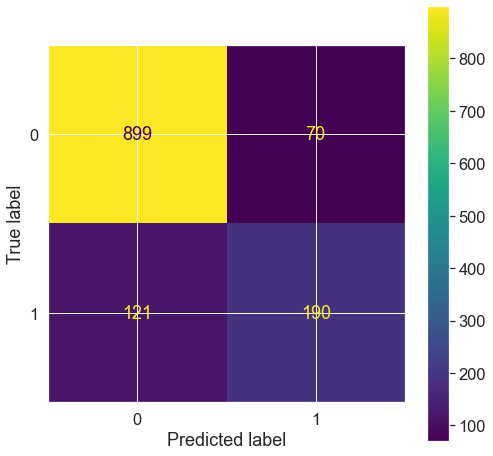

In [62]:
model_lr=LogisticRegression(C=10)
model_lr.fit(x_train,y_train)

print('Confusion Matrix')
plot_confusion_matrix(model_lr, x_test, y_test)

With C=10 we were able to correctly predict one more positive instance.

### SVM

Now, we will see if we can improve the accuracy of our predictions if we apply another machine learning algorithm.

We can build a model based on support vectors (SVM). Although this machine learning algorithm is more computationally 
demanding than Logistic Regression, the size of our data set permits us to use SVM to make our predictions.

We will also include hyperparameter optimization in this model: we will search for the best value for the hyperparameter C, 
which represents the inverse of regularization strength as well as the best value of the parameter gamma, which can be seen
as the inverse of the radius of influence of samples selected by the model as support vectors.

In [63]:
from sklearn.svm import SVC

model_svm=SVC()

model_svm.fit(x_train,y_train)

pred_test=model_svm.predict(x_test)
print('Model test F1 score: %.5f'% f1_score(y_test,pred_test))
print('Model test accuracy: %.5f'% accuracy_score(y_test,pred_test))
print('Model test precision: %.5f'% precision_score(y_test,pred_test))

Model test F1 score: 0.64000
Model test accuracy: 0.83828
Model test precision: 0.69697


Confusion Matrix


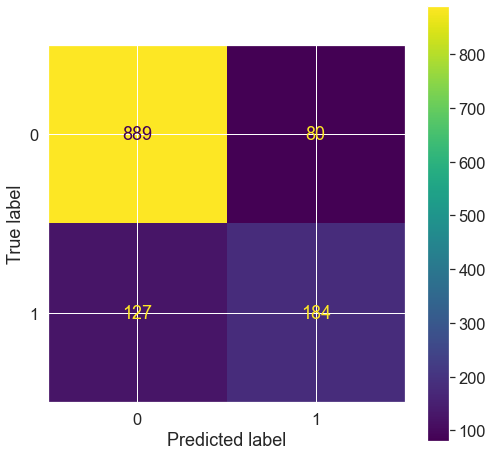

In [64]:
print('Confusion Matrix')
plot_confusion_matrix(model_svm, x_test, y_test)

Default SVM classifier was able to predict 1 more positive instance as compared to the logistic regression model, although the 
formal model showed lower accuracy on the test data.

### KNN

In [65]:
from sklearn.neighbors import KNeighborsClassifier

model_knn=KNeighborsClassifier()

model_knn.fit(x_train,y_train)

pred_test=model_knn.predict(x_test)
print('Model test F1 score: %.5f'% f1_score(y_test,pred_test))
print('Model test accuracy: %.5f'% accuracy_score(y_test,pred_test))
print('Model test precision: %.5f'% precision_score(y_test,pred_test))

Model test F1 score: 0.56716
Model test accuracy: 0.81875
Model test precision: 0.67556


Confusion Matrix


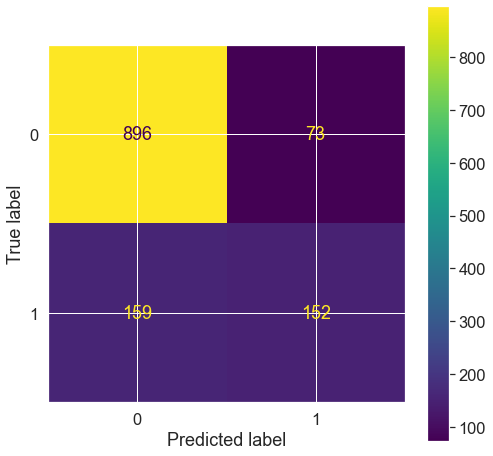

In [66]:
print('Confusion Matrix')
plot_confusion_matrix(model_knn, x_test, y_test)

### Decision tree

In [67]:
from sklearn import tree

model_dt=tree.DecisionTreeClassifier(random_state=5)
model_dt.fit(x_train,y_train)

pred_test=model_dt.predict(x_test)
print('Model test F1 score: %.5f'% f1_score(y_test,pred_test))
print('Model test accuracy: %.5f'% accuracy_score(y_test,pred_test))
print('Model test precision: %.5f'% precision_score(y_test,pred_test))

Model test F1 score: 0.57835
Model test accuracy: 0.79609
Model test precision: 0.58117


Confusion Matrix


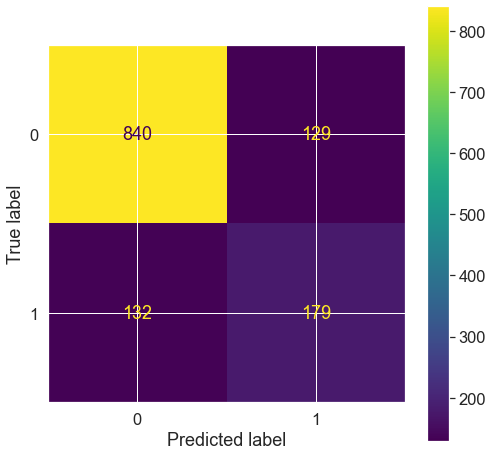

In [68]:
print('Confusion Matrix')
plot_confusion_matrix(model_dt, x_test, y_test)

### Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
model_rf=RandomForestClassifier(max_depth=20,n_estimators=200,random_state=5)
model_rf.fit(x_train,y_train)

pred_test=model_rf.predict(x_test)
print('Model test F1 score: %.5f'% f1_score(y_test,pred_test))
print('Model test accuracy: %.5f'% accuracy_score(y_test,pred_test))
print('Model test precision: %.5f'% precision_score(y_test,pred_test))

Model test F1 score: 0.65709
Model test accuracy: 0.85078
Model test precision: 0.74390


<AxesSubplot:>

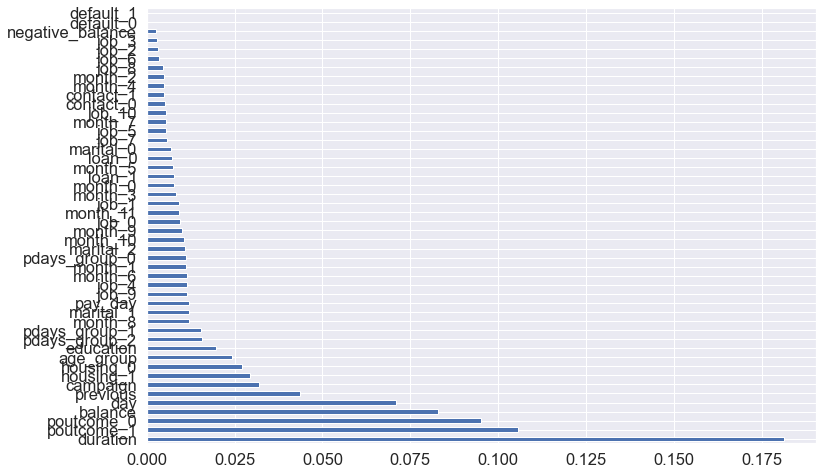

In [70]:
importances=pd.Series(model_rf.feature_importances_,index=X_scaled.columns)
importances.sort_values(axis=0, ascending=False).plot(kind='barh',figsize=(12,8))

We can see that features age_group and pdays_group that we previously engineered are among the top 12 important features
in this random forest model.

### Tune hyperparameters

In [83]:
from sklearn.model_selection import GridSearchCV

paramgrid={'max_depth':list(range(15,25,5)),'n_estimators':list(range(50,200,10))}
grid_search=GridSearchCV(RandomForestClassifier(random_state=5),paramgrid)

# Fit the grid search model
grid_search.fit(x_train,y_train)
grid_search.best_estimator_

RandomForestClassifier(max_depth=20, n_estimators=130, random_state=5)

In [84]:
model_rf=RandomForestClassifier(max_depth=20,n_estimators=130,random_state=5)
model_rf.fit(x_train,y_train)

pred_test=model_rf.predict(x_test)
print('Model test F1 score: %.5f'% f1_score(y_test,pred_test))
print('Model test accuracy: %.5f'% accuracy_score(y_test,pred_test))
print('Model test precision: %.5f'% precision_score(y_test,pred_test))

Model test F1 score: 0.66786
Model test accuracy: 0.85547
Model test precision: 0.75610


Confusion Matrix


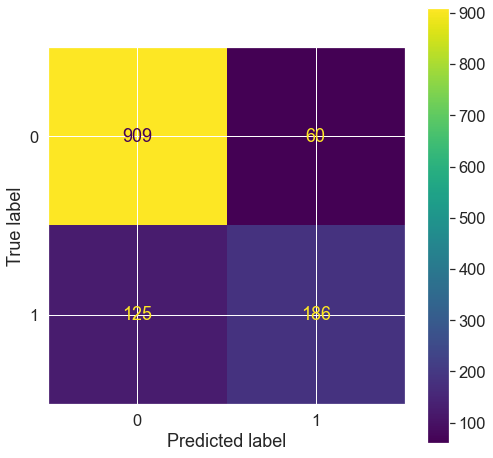

In [73]:
print('Confusion Matrix')
plot_confusion_matrix(model_rf, x_test, y_test)

By tuning the hyperparameters of the random forest model, we were able to correctly predic seven more positive instance.

### Change the decision probability treshold

In [74]:
threshold_list = list(np.arange(0.3,0.7,0.05))

for threshold in threshold_list:
    print('probability threshold ',threshold)
    y_pred = (model_rf.predict_proba(x_test)[:,1] >= threshold).astype(bool)

    accuracy = accuracy_score(y_test, y_pred)
    F1=f1_score(y_test,y_pred)
    print('Model test F1 score:',F1)
    print('Model test accuracy:',accuracy)
    print('------------------------------------')

probability threshold  0.3
Model test F1 score: 0.7019498607242339
Model test accuracy: 0.8328125
------------------------------------
probability threshold  0.35
Model test F1 score: 0.6994047619047619
Model test accuracy: 0.8421875
------------------------------------
probability threshold  0.39999999999999997
Model test F1 score: 0.6903225806451613
Model test accuracy: 0.85
------------------------------------
probability threshold  0.44999999999999996
Model test F1 score: 0.6655290102389078
Model test accuracy: 0.846875
------------------------------------
probability threshold  0.49999999999999994
Model test F1 score: 0.6678635547576302
Model test accuracy: 0.85546875
------------------------------------
probability threshold  0.5499999999999999
Model test F1 score: 0.6431226765799257
Model test accuracy: 0.85
------------------------------------
probability threshold  0.5999999999999999
Model test F1 score: 0.6027397260273973
Model test accuracy: 0.84140625
----------------------

Best treshold for test accuracy is 0.5.

### Recursive feature elimination

In [75]:
from sklearn.feature_selection import RFE
model=RandomForestClassifier(max_depth=20,n_estimators=130,random_state=5)

for index in range(1,X_scaled.shape[1]+1):
    
    print('Selected features: ', index)
    model_rfe=RFE(model,n_features_to_select=index)
    model_rfe.fit(x_train,y_train)
    x_train_rfe=model_rfe.transform(x_train)
    x_test_rfe=model_rfe.transform(x_test)
    model.fit(x_train_rfe,y_train)
    pred_test=model.predict(x_test_rfe)
    print('Test accuracy score: ', accuracy_score(y_test,pred_test))
    print('*******************************************')  

Selected features:  1
Test accuracy score:  0.75390625
*******************************************
Selected features:  2
Test accuracy score:  0.7390625
*******************************************
Selected features:  3
Test accuracy score:  0.828125
*******************************************
Selected features:  4
Test accuracy score:  0.8453125
*******************************************
Selected features:  5
Test accuracy score:  0.84609375
*******************************************
Selected features:  6
Test accuracy score:  0.8375
*******************************************
Selected features:  7
Test accuracy score:  0.84140625
*******************************************
Selected features:  8
Test accuracy score:  0.83671875
*******************************************
Selected features:  9
Test accuracy score:  0.84140625
*******************************************
Selected features:  10
Test accuracy score:  0.83671875
*******************************************
Selected features

We can get the highest accuracy on the test data with all the 48 features selected features.

In [76]:
select=RFE(model,n_features_to_select=48)
select.fit(x_train,y_train)
x_train_rfe=select.transform(x_train)
x_test_rfe=select.transform(x_test)
model.fit(x_train_rfe,y_train)
pred_test=model.predict(x_test_rfe)
print('Model test F1 score: %.5f'% f1_score(y_test,pred_test))
print('Model test accuracy: %.5f'% accuracy_score(y_test,pred_test))
print('Model test precision: %.5f'% precision_score(y_test,pred_test))

Model test F1 score: 0.66786
Model test accuracy: 0.85547
Model test precision: 0.75610


In [77]:
#features=X_scaled.columns[select.get_support()]
#features

Confusion Matrix


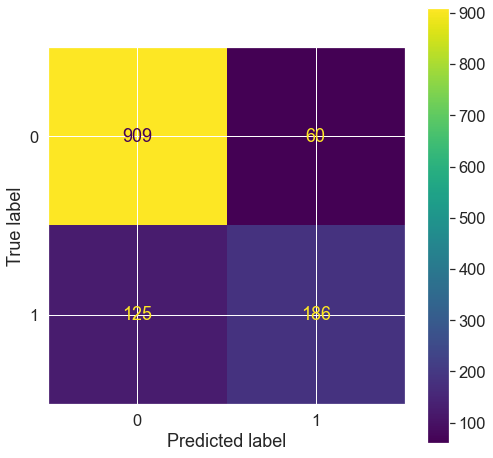

In [78]:
print('Confusion Matrix')
plot_confusion_matrix(model, x_test_rfe, y_test)

With feature selection we were able to correctly predict 15 more positive instances.

### XGBoost

In [79]:
from xgboost import XGBClassifier
model_xgb=XGBClassifier(random_state=5,max_depth=18)
model_xgb.fit(x_train, y_train)
pred_test=model_xgb.predict(x_test)
print('Model test F1 score: %.5f'% f1_score(y_test,pred_test))
print('Model test accuracy: %.5f'% accuracy_score(y_test,pred_test))
print('Model test precision: %.5f'% precision_score(y_test,pred_test))

Model test F1 score: 0.66216
Model test accuracy: 0.84375
Model test precision: 0.69751


Confusion Matrix


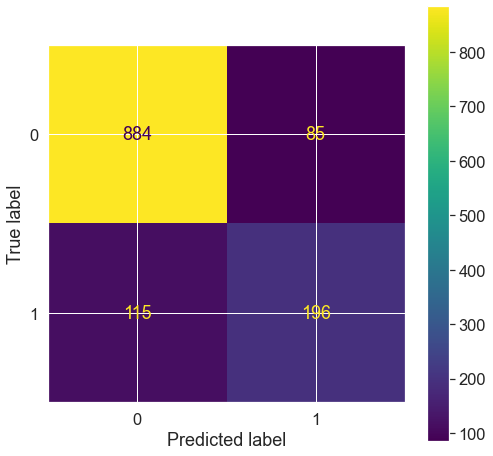

In [80]:
print('Confusion Matrix')
plot_confusion_matrix(model_xgb, x_test, y_test)

## Conclusions

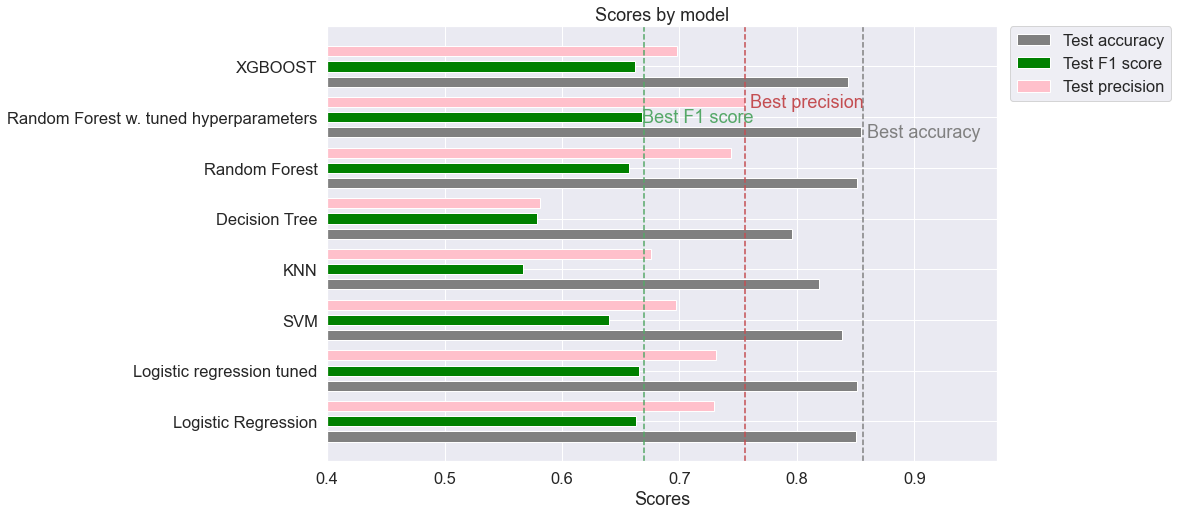

In [81]:
labels = ['Logistic Regression','Logistic regression tuned','SVM','KNN','Decision Tree','Random Forest',
          'Random Forest w. tuned hyperparameters','XGBOOST']
model_test_accuracy = [0.85000,0.85078, 0.83828,0.81875,0.79609,0.85078,0.8547,0.84375]
model_test_F1_score = [0.66316,0.66550,0.64000,0.56716,0.57835,0.65709,0.66786,0.66216]
model_test_precision=[0.72973,0.73077,0.69697,0.67556,0.58117,0.74390,0.75610,0.69751]

x = np.array([0,1,2,3,4,5,6,7])  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.barh(x - 0.3,model_test_accuracy,width,label='Test accuracy',color='grey')
rects2 = ax.barh(x,model_test_F1_score,width, label='Test F1 score',color='green')
rects3 = ax.barh(x + 0.3,model_test_precision,width, label='Test precision',color='pink')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Scores')
ax.set_title('Scores by model')
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.xlim(xmin=0.4, xmax=0.97)
ax.axvline(0.856, ls='--', color='grey')
plt.text(0.86, 5.6, 'Best accuracy',color='grey')
ax.axvline(0.67, ls='--', color='g')
plt.text(0.668, 5.9, 'Best F1 score',color='g')
ax.axvline(0.75610, ls='--', color='r')
plt.text(0.76, 6.2, 'Best precision',color='r')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x()+0.1 , height),
                    xytext=(0, 3),  # 4 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

Overall, we can say that Logistic Regression, random Forest and XGBoost models showed similar accuracy on the test data.

Random forest model with tuned hyperparameters has shown the best accuracy, F1 score and precision,with the last one being really important given that our objective was to predict the highest number of deposit subscribers.